# 数据分析
**目的**：数据分析的价值主要在于熟悉了解整个数据集的基本情况包括每个文件里有哪些数据，具体的文件中的每个字段表示什么实际含义，以及数据集中特征之间的相关性，在推荐场景下主要就是分析用户本身的基本属性，文章基本属性，以及用户和文章交互的一些分布，这些都有利于后面的召回策略的选择，以及特征工程。

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Times New Roman', size=13)

import os,gc,re,warnings,sys
warnings.filterwarnings("ignore")

DATA_PATH = "./data/"

## 读取数据

### 训练集（日志）

In [2]:
#training 20万用户的日志数据
trn_click = pd.read_csv(DATA_PATH + "train_click_log.csv")
trn_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,199999,160417,1507029570190,4,1,17,1,13,1
1,199999,5408,1507029571478,4,1,17,1,13,1
2,199999,50823,1507029601478,4,1,17,1,13,1
3,199998,157770,1507029532200,4,1,17,1,25,5
4,199998,96613,1507029671831,4,1,17,1,25,5


**数据特征说明**：
1. user_id: 用户的唯一标识
2. click_article_id: 用户点击的文章唯一标识
3. click_timestamp: 用户点击文章时的时间戳
4. click_environment: 用户点击文章的环境
5. click_deviceGroup: 用户点击文章的设备组
6. click_os: 用户点击文章时的操作系统
7. click_country: 用户点击文章时的所在的国家
8. click_region: 用户点击文章时所在的区域
9. click_referrer_type: 用户点击文章时，文章的来源

In [3]:
trn_click.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112623 entries, 0 to 1112622
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype
---  ------               --------------    -----
 0   user_id              1112623 non-null  int64
 1   click_article_id     1112623 non-null  int64
 2   click_timestamp      1112623 non-null  int64
 3   click_environment    1112623 non-null  int64
 4   click_deviceGroup    1112623 non-null  int64
 5   click_os             1112623 non-null  int64
 6   click_country        1112623 non-null  int64
 7   click_region         1112623 non-null  int64
 8   click_referrer_type  1112623 non-null  int64
dtypes: int64(9)
memory usage: 76.4 MB


### 文章信息

In [4]:
# 此处读取的文章信息中，其对应的文章ID与训练集中的应相同
item_df = pd.read_csv(DATA_PATH + "articles.csv")
item_df.head()

,article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162


In [5]:
# 总共36万篇文章
item_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   words_count    364047 non-null  int64
dtypes: int64(4)
memory usage: 11.1 MB


### 文章Embedding信息

In [6]:
item_emb_df = pd.read_csv(DATA_PATH + "articles_emb.csv")
item_emb_df.head()

,article_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249
0,0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,...,-0.487843,0.823124,0.412688,-0.338654,0.320786,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


### 测试集

In [7]:
# testing 5万用户的数据，且与训练集的数据不相重叠
tst_click = pd.read_csv(DATA_PATH + "testA_click_log.csv")
tst_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,249999,160974,1506959142820,4,1,17,1,13,2
1,249999,160417,1506959172820,4,1,17,1,13,2
2,249998,160974,1506959056066,4,1,12,1,13,2
3,249998,202557,1506959086066,4,1,12,1,13,2
4,249997,183665,1506959088613,4,1,17,1,15,5


In [8]:
tst_click.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518010 entries, 0 to 518009
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   user_id              518010 non-null  int64
 1   click_article_id     518010 non-null  int64
 2   click_timestamp      518010 non-null  int64
 3   click_environment    518010 non-null  int64
 4   click_deviceGroup    518010 non-null  int64
 5   click_os             518010 non-null  int64
 6   click_country        518010 non-null  int64
 7   click_region         518010 non-null  int64
 8   click_referrer_type  518010 non-null  int64
dtypes: int64(9)
memory usage: 35.6 MB


## 数据预处理

In [9]:
# 修改对应特征名称
item_df.rename(columns={"article_id":"click_article_id"}, inplace=True)

In [10]:
# 对每一位用户按照时间序列进行rank, 时间越靠前级别越高
trn_click["rank"] = trn_click.groupby("user_id")["click_timestamp"].rank(ascending=False).astype(int)
tst_click["rank"] = tst_click.groupby("user_id")["click_timestamp"].rank(ascending=False).astype(int)

In [11]:
# 统计每一个用户所点击的文章数目
trn_click["click_cnts"] = trn_click.groupby("user_id")["click_timestamp"].transform("count")  # 填充
tst_click["click_cnts"] = tst_click.groupby("user_id")["click_timestamp"].transform("count")

In [12]:
trn_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts
0,199999,160417,1507029570190,4,1,17,1,13,1,11,11
1,199999,5408,1507029571478,4,1,17,1,13,1,10,11
2,199999,50823,1507029601478,4,1,17,1,13,1,9,11
3,199998,157770,1507029532200,4,1,17,1,25,5,40,40
4,199998,96613,1507029671831,4,1,17,1,25,5,39,40


In [13]:
#　训练集(合并文章属性特征)
trn_click = trn_click.merge(item_df, how="left", on=["click_article_id"])
trn_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,199999,160417,1507029570190,4,1,17,1,13,1,11,11,281,1506942089000,173
1,199999,5408,1507029571478,4,1,17,1,13,1,10,11,4,1506994257000,118
2,199999,50823,1507029601478,4,1,17,1,13,1,9,11,99,1507013614000,213
3,199998,157770,1507029532200,4,1,17,1,25,5,40,40,281,1506983935000,201
4,199998,96613,1507029671831,4,1,17,1,25,5,39,40,209,1506938444000,185


In [14]:
trn_click.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1112623 entries, 0 to 1112622
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype
---  ------               --------------    -----
 0   user_id              1112623 non-null  int64
 1   click_article_id     1112623 non-null  int64
 2   click_timestamp      1112623 non-null  int64
 3   click_environment    1112623 non-null  int64
 4   click_deviceGroup    1112623 non-null  int64
 5   click_os             1112623 non-null  int64
 6   click_country        1112623 non-null  int64
 7   click_region         1112623 non-null  int64
 8   click_referrer_type  1112623 non-null  int64
 9   rank                 1112623 non-null  int64
 10  click_cnts           1112623 non-null  int64
 11  category_id          1112623 non-null  int64
 12  created_at_ts        1112623 non-null  int64
 13  words_count          1112623 non-null  int64
dtypes: int64(14)
memory usage: 127.3 MB


In [15]:
trn_click.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,1112623.0,1.221198e+05,5.540349e+04,0.000000e+00,7.934700e+04,1.309670e+05,1.704010e+05,1.999990e+05
click_article_id,1112623.0,1.951541e+05,9.292286e+04,3.000000e+00,1.239090e+05,2.038900e+05,2.777120e+05,3.640460e+05
click_timestamp,1112623.0,1.507588e+12,3.363466e+08,1.507030e+12,1.507297e+12,1.507596e+12,1.507841e+12,1.510603e+12
click_environment,1112623.0,3.947786e+00,3.276715e-01,1.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
click_deviceGroup,1112623.0,1.815981e+00,1.035170e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,5.000000e+00
click_os,1112623.0,1.301976e+01,6.967844e+00,2.000000e+00,2.000000e+00,1.700000e+01,1.700000e+01,2.000000e+01
click_country,1112623.0,1.310776e+00,1.618264e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.100000e+01
click_region,1112623.0,1.813587e+01,7.105832e+00,1.000000e+00,1.300000e+01,2.100000e+01,2.500000e+01,2.800000e+01
click_referrer_type,1112623.0,1.910063e+00,1.220012e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00
rank,1112623.0,7.118518e+00,1.016095e+01,1.000000e+00,2.000000e+00,4.000000e+00,8.000000e+00,2.410000e+02


In [16]:
# 用户数目
trn_click["user_id"].nunique()

200000

In [17]:
# 每一位用户至少阅读两篇文章
trn_click.groupby("user_id")["click_timestamp"].count().min()

2

## 统计用户的使用特征数目

In [18]:
trn_click["click_os"].value_counts().reset_index()

,index,click_os
0,17,648777
1,2,310298
2,20,121057
3,12,20308
4,13,8721
5,19,2914
6,5,531
7,3,17


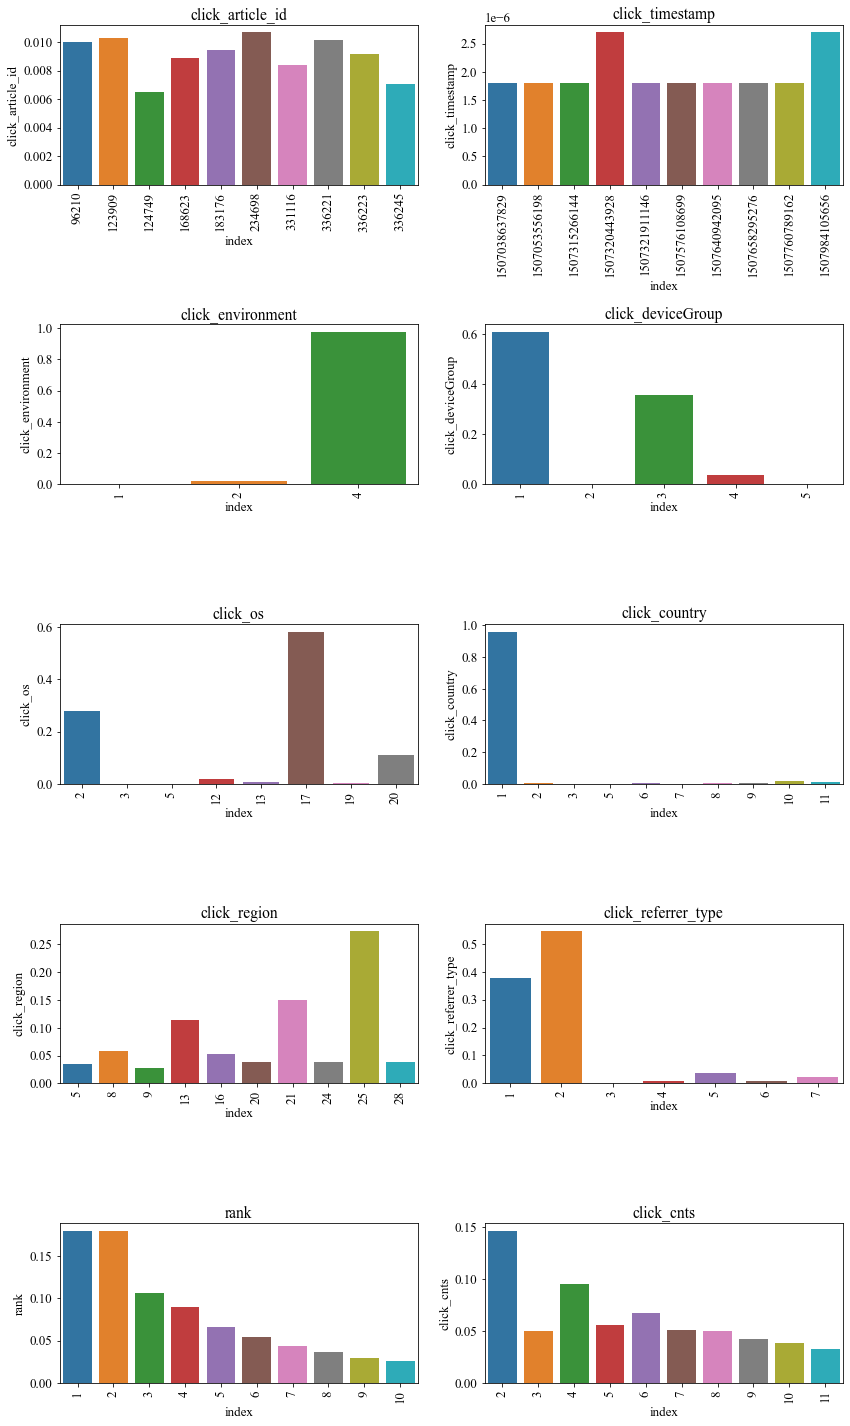

In [19]:
plt.figure(figsize=(12, 20))
i = 1

for col in ['click_article_id', 'click_timestamp', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 
            'click_region', 'click_referrer_type', 'rank', 'click_cnts']:
    
    plot_envs = plt.subplot(5, 2, i)
    i += 1
    # 训练集
    v = trn_click[col].value_counts(normalize=True).reset_index()[:10]
    fig = sns.barplot(x=v["index"], y=v[col])
    for f in fig.get_xticklabels():
        f.set_rotation(90)
    plt.title(col)
    
plt.tight_layout()
plt.savefig("imgs/数据分布情况.png")

## 测试集用户日志

In [20]:
# 测试与训练的中用户ID没有重复
tst_click = tst_click.merge(item_df, how='left', on=['click_article_id'])
tst_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,249999,160974,1506959142820,4,1,17,1,13,2,19,19,281,1506912747000,259
1,249999,160417,1506959172820,4,1,17,1,13,2,18,19,281,1506942089000,173
2,249998,160974,1506959056066,4,1,12,1,13,2,5,5,281,1506912747000,259
3,249998,202557,1506959086066,4,1,12,1,13,2,4,5,327,1506938401000,219
4,249997,183665,1506959088613,4,1,17,1,15,5,7,7,301,1500895686000,256


In [21]:
tst_click.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 518010 entries, 0 to 518009
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   user_id              518010 non-null  int64
 1   click_article_id     518010 non-null  int64
 2   click_timestamp      518010 non-null  int64
 3   click_environment    518010 non-null  int64
 4   click_deviceGroup    518010 non-null  int64
 5   click_os             518010 non-null  int64
 6   click_country        518010 non-null  int64
 7   click_region         518010 non-null  int64
 8   click_referrer_type  518010 non-null  int64
 9   rank                 518010 non-null  int64
 10  click_cnts           518010 non-null  int64
 11  category_id          518010 non-null  int64
 12  created_at_ts        518010 non-null  int64
 13  words_count          518010 non-null  int64
dtypes: int64(14)
memory usage: 59.3 MB


In [22]:
tst_click.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,518010.0,2.273424e+05,1.461391e+04,2.000000e+05,2.149260e+05,2.291090e+05,2.401820e+05,2.499990e+05
click_article_id,518010.0,1.938038e+05,8.827939e+04,1.370000e+02,1.285510e+05,1.991970e+05,2.721430e+05,3.640430e+05
click_timestamp,518010.0,1.507387e+12,3.706127e+08,1.506959e+12,1.507026e+12,1.507308e+12,1.507666e+12,1.508832e+12
click_environment,518010.0,3.947300e+00,3.239161e-01,1.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
click_deviceGroup,518010.0,1.738285e+00,1.020858e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,5.000000e+00
click_os,518010.0,1.362847e+01,6.625564e+00,2.000000e+00,1.200000e+01,1.700000e+01,1.700000e+01,2.000000e+01
click_country,518010.0,1.348209e+00,1.703524e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.100000e+01
click_region,518010.0,1.825025e+01,7.060798e+00,1.000000e+00,1.300000e+01,2.100000e+01,2.500000e+01,2.800000e+01
click_referrer_type,518010.0,1.819614e+00,1.082657e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00
rank,518010.0,1.552179e+01,3.395770e+01,1.000000e+00,4.000000e+00,8.000000e+00,1.800000e+01,9.380000e+02


In [23]:
# 五万测试用户
tst_click.user_id.nunique()

50000

In [24]:
# 测试否有训练集重复用户
tst_click.user_id.isin(trn_click.user_id).sum()

0

In [25]:
# 测试集中，每一位用户至少点击一篇文章
tst_click.groupby('user_id')['click_article_id'].count().min()

1

## 新闻文章信息数据表

In [26]:
item_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   click_article_id  364047 non-null  int64
 1   category_id       364047 non-null  int64
 2   created_at_ts     364047 non-null  int64
 3   words_count       364047 non-null  int64
dtypes: int64(4)
memory usage: 11.1 MB


In [27]:
item_df.head().append(item_df.tail())

,click_article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162
364042,364042,460,1434034118000,144
364043,364043,460,1434148472000,463
364044,364044,460,1457974279000,177
364045,364045,460,1515964737000,126
364046,364046,460,1505811330000,479


(array([644.,  34.,  21.,  16.,  12.,  13.,   7.,  10.,   8.,   7.,   7.,
          9.,   5.,   8.,   7.,   9.,   7.,  12.,  10.,  20.]),
 array([1.0000e+00, 1.7520e+02, 3.4940e+02, 5.2360e+02, 6.9780e+02,
        8.7200e+02, 1.0462e+03, 1.2204e+03, 1.3946e+03, 1.5688e+03,
        1.7430e+03, 1.9172e+03, 2.0914e+03, 2.2656e+03, 2.4398e+03,
        2.6140e+03, 2.7882e+03, 2.9624e+03, 3.1366e+03, 3.3108e+03,
        3.4850e+03]),
 <BarContainer object of 20 artists>)

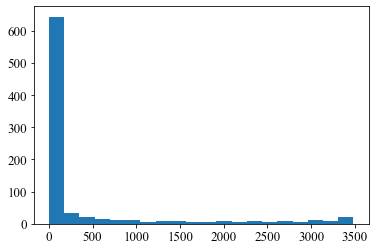

In [28]:
value = item_df["words_count"].value_counts()
plt.hist(value.values, bins=20)

**知识点:**  
频数分布直方图(hist：连续)<font color="red">条与条之间无间隔</font>，而条形统计图(bar：离散)有。  
1）条形统计图中，横轴上的数据是孤立的，是一个具体的数据。

    而直方图中，横轴上的数据是连续的，是一个范围。

2）条形统计图是用条形的高度表示频数的大小。

    而直方图是用长方形的面积表示频数，长方形的面积越大，就表示这组数据的频数越大；只有当长方形的宽都相等时，才可以用长方形的高表示频数的大小。

3）条形统计图中，各个数据之间是相对独立的，各个条形之间是有空隙的。

    而在直方图中，各长方形对应的是一个范围，由于每两个相邻范围之间不重叠、不遗漏，因此在直方图中，长方形之间没有空隙

461


<AxesSubplot:>

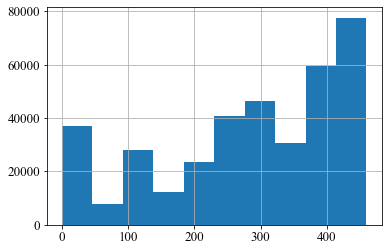

In [29]:
#　文章的分类主题更加倾向于id靠后的数据
print(item_df['category_id'].nunique())  # 461个文章主题
item_df['category_id'].hist()

<AxesSubplot:xlabel='category_id', ylabel='Density'>

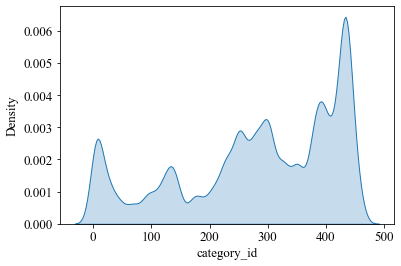

In [30]:
# 连续性随机变量可以绘制其概括密度曲线
sns.kdeplot(item_df['category_id'], shade=True)

**结论**：文章创建的主题大多分布在id400-500之间。

## 用户是否重复点击

In [31]:
# 全量数据
user_click_df = trn_click.append(tst_click)
user_click_df = user_click_df.reset_index(drop=True)
user_click_df.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,199999,160417,1507029570190,4,1,17,1,13,1,11,11,281,1506942089000,173
1,199999,5408,1507029571478,4,1,17,1,13,1,10,11,4,1506994257000,118
2,199999,50823,1507029601478,4,1,17,1,13,1,9,11,99,1507013614000,213
3,199998,157770,1507029532200,4,1,17,1,25,5,40,40,281,1506983935000,201
4,199998,96613,1507029671831,4,1,17,1,25,5,39,40,209,1506938444000,185


In [32]:
# 统计同一用户在不同时间段所点击的同一用户的次数
dub_cnts = user_click_df.groupby(["user_id", "click_article_id"])["click_timestamp"].agg(["count"])
dub_cnts = dub_cnts.reset_index()

In [33]:
# 用户重复点击次数超过七次的数据
dub_cnts[dub_cnts["count"]>7]

,user_id,click_article_id,count
311242,86295,74254,10
311243,86295,76268,10
393761,103237,205948,10
393763,103237,235689,10
576902,134850,69463,13


In [34]:
dub_cnts["count"].unique()

array([ 1,  2,  4,  3,  6,  5, 10,  7, 13])

In [35]:
dub_cnts["count"].value_counts(normalize=True)

1     9.924795e-01
2     7.183625e-03
3     2.608631e-04
4     4.759824e-05
5     1.607213e-05
6     7.417907e-06
10    2.472636e-06
7     1.854477e-06
13    6.181589e-07
Name: count, dtype: float64

**结论：**约99.2%的用户不会进行重复广告点击，即只点击一次新闻，即很少有用户对新闻内容进行二次点击，因此推荐过程中应该减少大量重复内容的推荐，增加多样性。

## 用户点击情况变化分析

In [36]:
def plot_envs(df, cols, r, c):
    plt.figure()
    plt.figure(figsize=(10, 5))
    i = 1
    for col in cols:
        plt.subplot(r, c, i)
        i += 1
        v = df[col].value_counts().reset_index()
        v.rename(columns={"index":"classes"}, inplace=True)
        fig = sns.barplot(x=v['classes'], y=v[col])
        for item in fig.get_xticklabels():
            item.set_rotation(90)
        plt.title(col)
        
    plt.tight_layout()
    plt.show()

<Figure size 432x288 with 0 Axes>

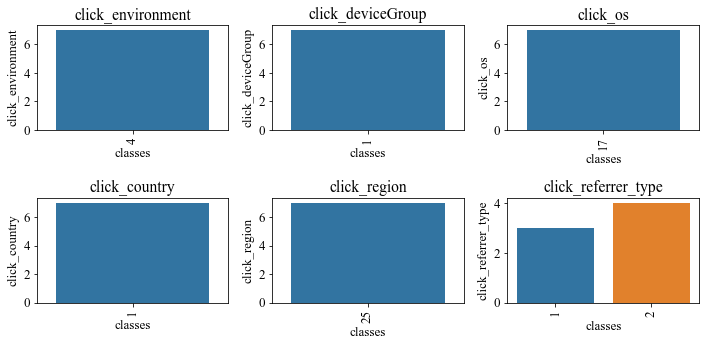

<Figure size 432x288 with 0 Axes>

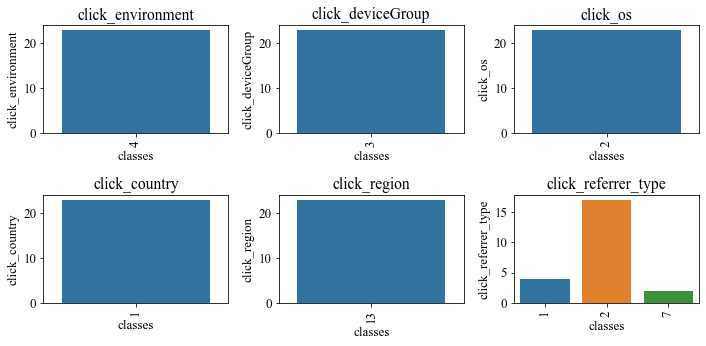

<Figure size 432x288 with 0 Axes>

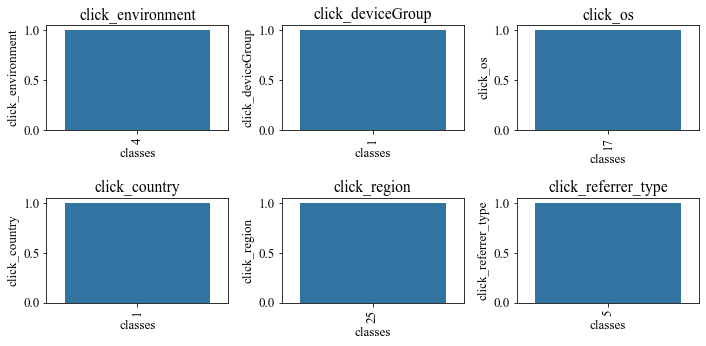

<Figure size 432x288 with 0 Axes>

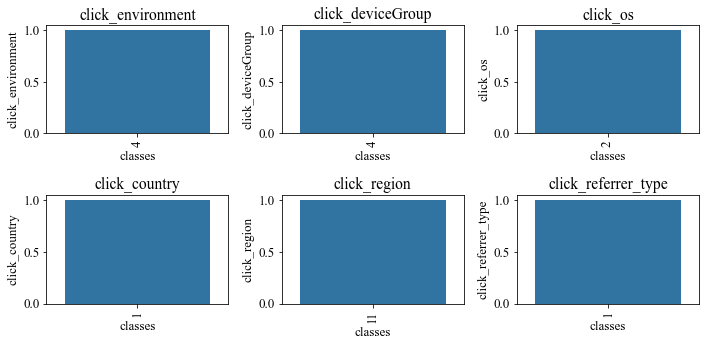

<Figure size 432x288 with 0 Axes>

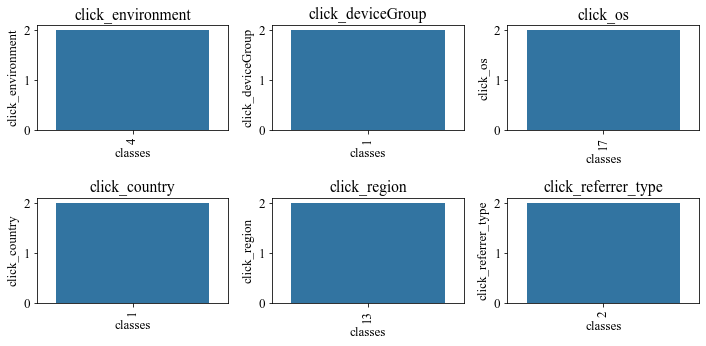

<Figure size 432x288 with 0 Axes>

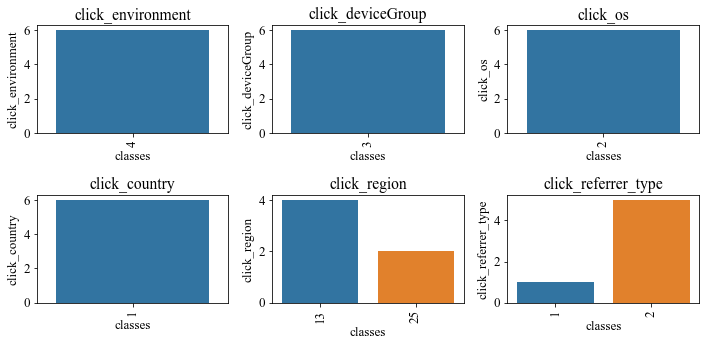

<Figure size 432x288 with 0 Axes>

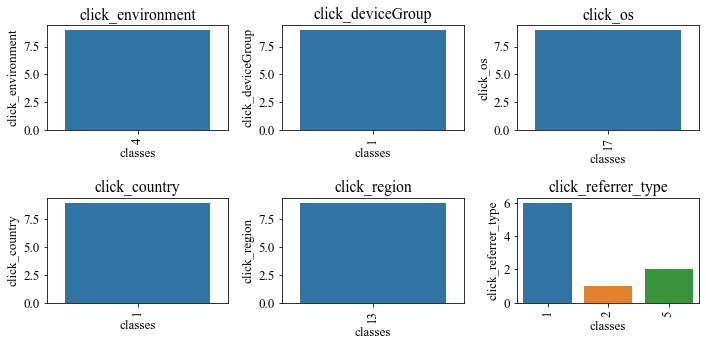

<Figure size 432x288 with 0 Axes>

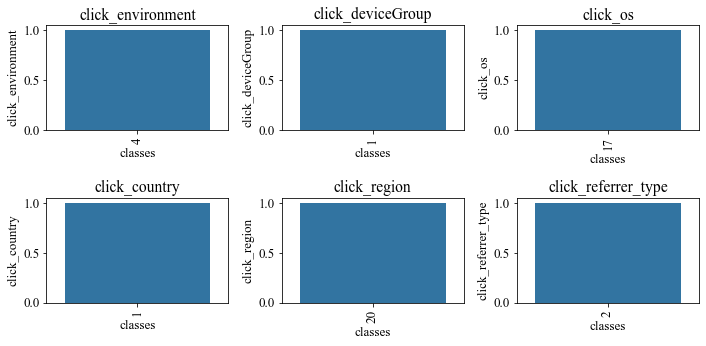

<Figure size 432x288 with 0 Axes>

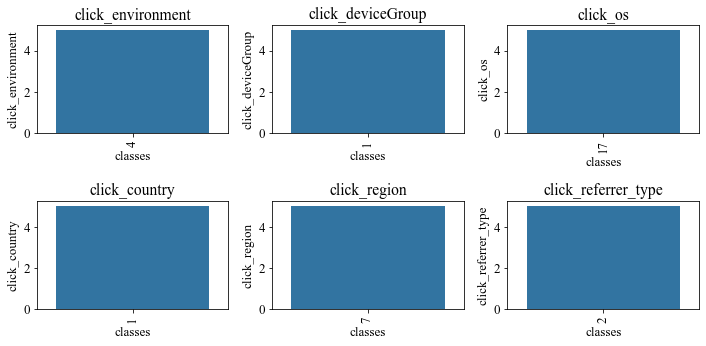

<Figure size 432x288 with 0 Axes>

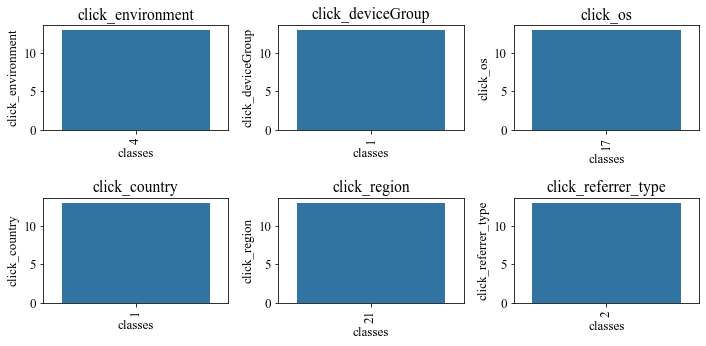

In [37]:
# 分析用户点击环境变化是否明显，这里随机采样10个用户分析这些用户的点击环境分布
sample_user_ids = np.random.choice(tst_click['user_id'].unique(), size=10, replace=False)
sample_users = user_click_df[user_click_df['user_id'].isin(sample_user_ids)]

# 用户点击环境
cols = ['click_environment','click_deviceGroup', 'click_os', 'click_country', 'click_region','click_referrer_type']

for _, user_df in sample_users.groupby('user_id'):
    plot_envs(user_df, cols, 2, 3)

**结论**：通过采样数据发现，用户的点击环境、点击设备组、点击操作系统和点击的国家集中稳定在同一类型中，而点击区域和点击来源有轻微的波动，整体趋于稳定，以上说明用户自身的点击环境表现出相对稳定的状态。

## 用户点击的文章数目情况
目的：查看用户的点击情况，分析活跃用户和不活跃用户。

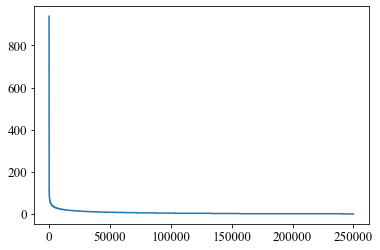

In [38]:
user_click_item_count = user_click_df.groupby("user_id")["click_article_id"].count()
plt.plot(sorted(user_click_item_count, reverse=True))

### 活跃用户

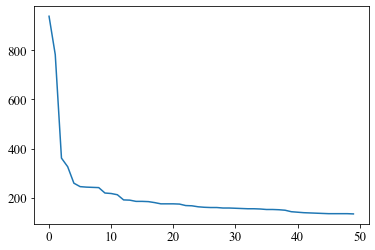

In [39]:
plt.plot(sorted(user_click_item_count, reverse=True)[:50])

**结论**：点击次数排前50的用户的点击次数都在100次以上。  
**思路**：<font color="red">我们可以定义点击次数大于等于100次的用户为活跃用户</font>，这是一种简单的处理思路， 判断用户活跃度，更加全面的是再结合上点击时间，后面我们会基于点击次数和点击时间两个方面来判断用户活跃度(区分累计用户活跃度和单位时间内的用户活跃度)。

### 不活跃用户

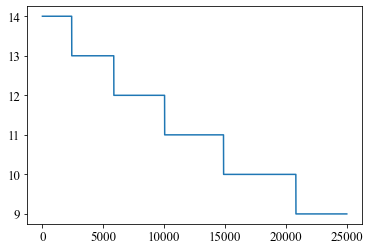

In [40]:
plt.plot(sorted(user_click_item_count, reverse=True)[25000:50000])

<AxesSubplot:ylabel='Density'>

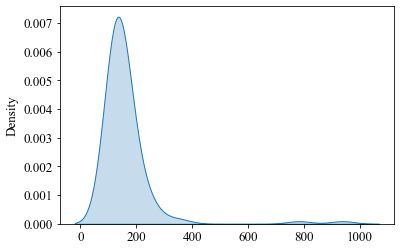

In [41]:
sns.kdeplot(sorted(user_click_item_count, reverse=True)[:100], shade=True)

**结论**：大多数用户点击文章次数较少，服从长尾分布, 因此可以在推荐过程中考虑去除活跃用户对整体推荐影响。

## 新闻点击次数分析(热门文章)
**目的**：统计每一篇新闻所阅读的用户数目,查看用户点击最多文章的点击数目。

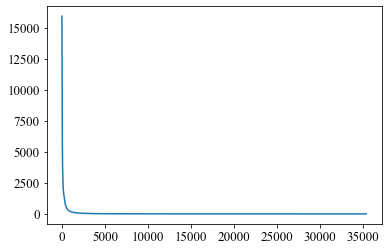

In [42]:
# 热门文章分析
article_cnts = sorted(user_click_df.groupby("click_article_id")["user_id"].count(), reverse=True)
plt.plot(article_cnts)

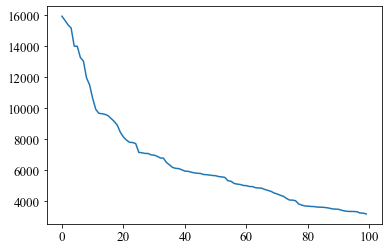

In [43]:
plt.plot(article_cnts[:100])

**结论**：点击次数最多的前100篇新闻，点击次数都是大于1000，因此可以设定文章点击次数的阈值，从而对热门文章进行区分，此外可以<font color="red">引入时间特征来区分短是时间内的热门文章和长时间的热门文章</font>。

### 热门新闻

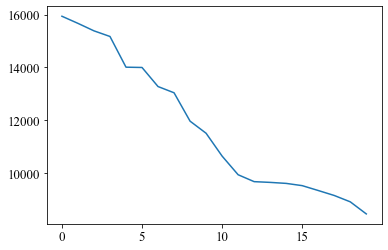

In [44]:
# 热门新闻可以在多路召回过程中进行候选推荐
plt.plot(article_cnts[:20])

### 冷门新闻

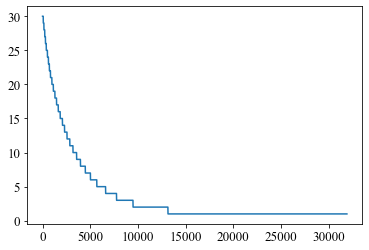

In [45]:
# 大多数新闻被用户极少读到
plt.plot(article_cnts[3500:])

<AxesSubplot:ylabel='Density'>

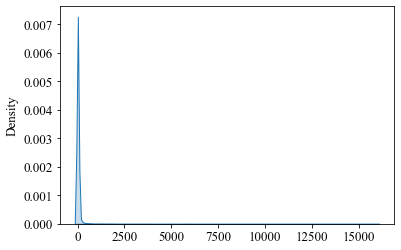

In [46]:
# 新闻点击情况呈现偏态分布
sns.kdeplot(article_cnts, shade=True)

**结论：**召回阶段可以考虑对热门新闻进行召回，能够体现新闻"新"的特点。

## 新闻共现频率

In [47]:
# 同一新闻下一次被点击的次数
tmp = user_click_df.sort_values("click_timestamp")
tmp["next_item"] = tmp.groupby("user_id")["click_article_id"].transform(lambda x:x.shift(-1))

In [48]:
union_tmp = tmp.groupby(["click_article_id", "next_item"]
                       )["click_timestamp"].agg(["count"]
                                               ).reset_index().sort_values("count", ascending=False)
union_tmp.describe().T

,count,mean,std,min,25%,50%,75%,max
click_article_id,433597.0,187340.537462,95745.859867,69.0,108856.0,198659.0,272145.0,364046.0
next_item,433597.0,188408.262237,96211.486060,3.0,107253.0,202289.0,272428.0,364043.0
count,433597.0,3.184139,18.851753,1.0,1.0,1.0,2.0,2202.0


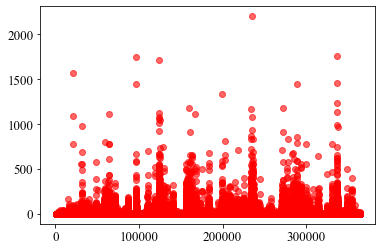

In [49]:
# 从中可以看出大多数文章都具有共现性
plt.scatter(x=union_tmp.click_article_id, y=union_tmp["count"]
            , c="r"
            , alpha=0.6
           )

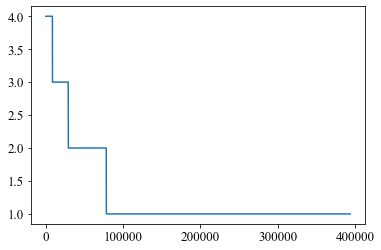

In [50]:
# 至少有70000对数据出现了至少一次共现的情况
plt.plot(union_tmp["count"].values[40000:])

## 新闻文章类别信息

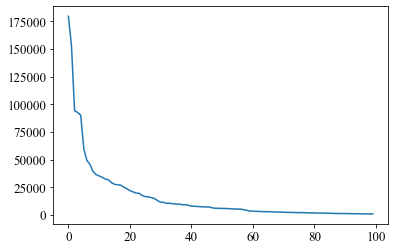

In [51]:
# 前100个热门文章类型的出现较为频繁
plt.plot(user_click_df["category_id"].value_counts().values[:100])

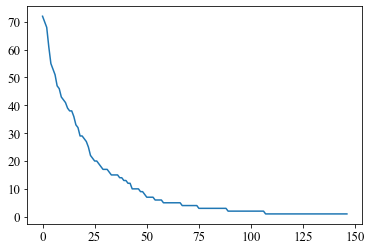

In [52]:
# 冷门文章类型的数目较少
plt.plot(user_click_df["category_id"].value_counts().values[150:])

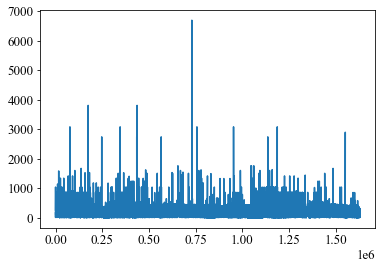

In [53]:
plt.plot(user_click_df['words_count'].values)

(array([1.615704e+06, 7.795000e+03, 6.977000e+03, 8.800000e+01,
        5.000000e+01, 6.000000e+00, 0.000000e+00, 0.000000e+00,
        5.000000e+00, 5.000000e+00, 0.000000e+00, 2.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00]),
 array([   0. ,  334.5,  669. , 1003.5, 1338. , 1672.5, 2007. , 2341.5,
        2676. , 3010.5, 3345. , 3679.5, 4014. , 4348.5, 4683. , 5017.5,
        5352. , 5686.5, 6021. , 6355.5, 6690. ]),
 <BarContainer object of 20 artists>)

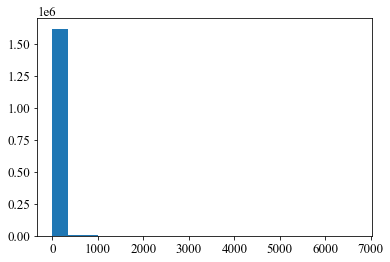

In [54]:
# 大多数文章的字数篇幅都在600子之内
plt.hist(user_click_df['words_count'].values, bins=20)

## 用户点击新闻类型的偏好
目的：查看用户所观看的文章类型，找出共性，且此特征可以用于度量用户的兴趣是否广泛

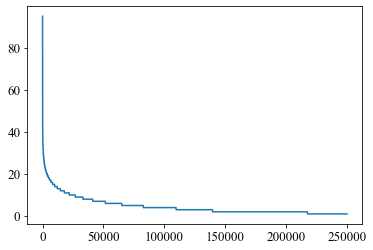

In [55]:
plt.plot(sorted(user_click_df.groupby("user_id")["category_id"].nunique(), reverse=True))

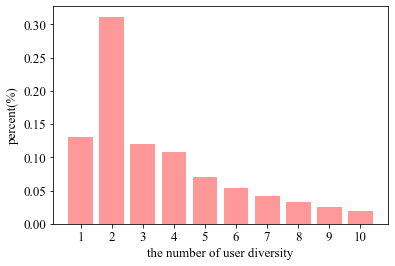

In [56]:
# 每位用户阅读文章的多样性
bar_data = user_click_df.groupby("user_id")["category_id"].nunique().value_counts(normalize=True)[:10]
plt.bar(bar_data.index, bar_data.values, color="r", alpha=0.4)
plt.xticks(bar_data.index)
plt.ylabel("percent(%)")
plt.xlabel("the number of user diversity")
plt.show()

**结论：**用户喜欢点击新闻种类数目范围不大，其中30%的用户喜欢点击两种类型的文章，因此在推荐的过程中其多样性不能过于分散。

## 用户查看文章的长度分布
目的：通过统计不同用户点击新闻的平均字数，这个可以反映用户是对长文更感兴趣还是对短文更感兴趣。

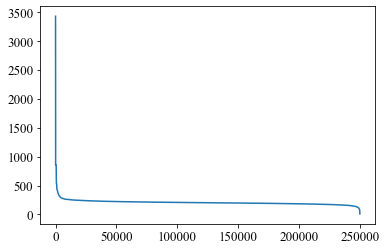

In [57]:
plt.plot(sorted(user_click_df.groupby('user_id')['words_count'].mean(), reverse=True))

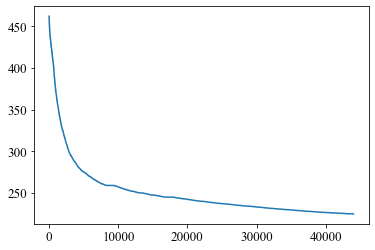

In [58]:
#挑出大多数人的区间仔细看看
plt.plot(sorted(user_click_df.groupby('user_id')['words_count'].mean(), reverse=True)[1000:45000])

**结论**：可以考虑在文章推荐的过程中，其它特征情况类似的条件下，优先推荐文章篇幅较少的文章。

### 知识点:箱线图
![](./imgs/Boxplot_vs_PDF.svg)

<AxesSubplot:>

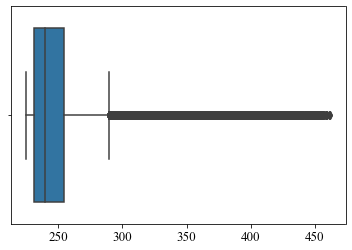

In [59]:
sns.boxplot(sorted(user_click_df.groupby('user_id')['words_count'].mean(), reverse=True)[1000:45000], orient="v")

## 用户点击新闻的时间分析

In [60]:
#为了更好的可视化，这里把时间进行归一化操作
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
user_click_df['click_timestamp'] = mm.fit_transform(user_click_df[['click_timestamp']])
user_click_df['created_at_ts'] = mm.fit_transform(user_click_df[['created_at_ts']])

# 按照时间序列进行排序
user_click_df = user_click_df.sort_values('click_timestamp')

In [61]:
user_click_df

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
1112641,249990,162300,0.000000,4,3,20,1,25,2,5,5,281,0.989186,193
1112625,249998,160974,0.000002,4,1,12,1,13,2,5,5,281,0.989092,259
1112653,249985,160974,0.000003,4,1,17,1,8,2,8,8,281,0.989092,259
1112673,249979,162300,0.000004,4,1,17,1,25,2,2,2,281,0.989186,193
1112648,249988,160974,0.000004,4,1,17,1,21,2,17,17,281,0.989092,259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705656,121158,224148,0.779105,4,1,17,1,13,2,1,54,354,0.997195,212
925954,70254,207672,0.860177,4,1,17,1,20,2,2,14,331,0.998288,242
925955,70254,96333,0.860185,4,1,17,1,20,2,1,14,209,0.998272,299
1091177,2465,203538,0.999992,4,1,17,1,2,2,2,8,327,0.999741,275


In [62]:
# 每一位用户的平均点击时差均值
def mean_diff_time_fun(df, col):
    """计算时间差的均值"""
    
    df = pd.DataFrame(df, columns={col})
    df["time_shift1"] = df[col].shift(1).fillna(0)
    df["diff_time"] = abs(df[col]-df["time_shift1"])  # 做时间差
    
    return df["diff_time"].mean()

In [63]:
mean_diff_click_time = user_click_df.groupby("user_id")["created_at_ts", "click_timestamp"].apply(lambda x: mean_diff_time_fun(x, "click_timestamp"))

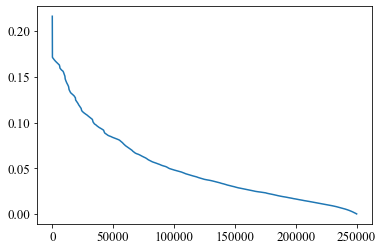

In [64]:
plt.plot(sorted(mean_diff_click_time.values, reverse=True))

结论：不同用户点击新闻所产生的时间差具有一定的差异性，可以将用户的时间差作为新闻点击的依据。

In [65]:
# 前后点击文章的创建时间差的平均值
mean_diff_created_time = user_click_df.groupby('user_id')['click_timestamp', 'created_at_ts'].apply(lambda x: mean_diff_time_fun(x, 'created_at_ts'))

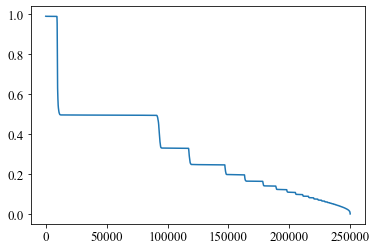

In [66]:
plt.plot(sorted(mean_diff_created_time.values, reverse=True))

## Word2Vec

In [67]:
from gensim.models import Word2Vec
import logging, pickle

In [68]:
# 需要注意这里模型只迭代了一次
def trian_item_word2vec(click_df, embed_size=16, save_name='item_w2v_emb.pkl', split_char=' '):
    click_df = click_df.sort_values('click_timestamp')
    # 只有转换成字符串才可以进行训练
    click_df['click_article_id'] = click_df['click_article_id'].astype(str)
    # 转换成句子的形式
    #[['30760', '157507'],
    #  ['289197', '63746'],
    #  ['36162', '168401'].....]
    docs = click_df.groupby(['user_id'])['click_article_id'].apply(lambda x: list(x)).reset_index()
    docs = docs['click_article_id'].values.tolist()

    # 为了方便查看训练的进度，这里设定一个log信息
    logging.basicConfig(format='%(asctime)s:%(levelname)s:%(message)s', level=logging.INFO)

    # 这里的参数对训练得到的向量影响也很大,默认负采样为5
    w2v = Word2Vec(docs, size=16, sg=1, window=5, seed=2020, workers=24, min_count=1, iter=10)
    
    # 保存成字典的形式
    item_w2v_emb_dict = {k: w2v[k] for k in click_df['click_article_id']}
    
    return item_w2v_emb_dict

In [69]:
# 得到词向量
item_w2v_emb_dict = trian_item_word2vec(user_click_df)

2021-01-14 12:26:10,586:INFO:collecting all words and their counts
2021-01-14 12:26:10,589:INFO:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-01-14 12:26:10,599:INFO:PROGRESS: at sentence #10000, processed 25727 words, keeping 3473 word types
2021-01-14 12:26:10,611:INFO:PROGRESS: at sentence #20000, processed 53883 words, keeping 5811 word types
2021-01-14 12:26:10,623:INFO:PROGRESS: at sentence #30000, processed 84881 words, keeping 7676 word types
2021-01-14 12:26:10,636:INFO:PROGRESS: at sentence #40000, processed 118390 words, keeping 9297 word types
2021-01-14 12:26:10,650:INFO:PROGRESS: at sentence #50000, processed 154179 words, keeping 10844 word types
2021-01-14 12:26:10,664:INFO:PROGRESS: at sentence #60000, processed 192350 words, keeping 12357 word types
2021-01-14 12:26:10,680:INFO:PROGRESS: at sentence #70000, processed 233685 words, keeping 13473 word types
2021-01-14 12:26:10,698:INFO:PROGRESS: at sentence #80000, processed 281335 words, keepin

In [70]:
# 随机选择15个用户，查看这些用户前后查看文章的相似性
sub_user_ids = np.random.choice(user_click_df.user_id.unique(), size=15, replace=False)
sub_user_info = user_click_df[user_click_df['user_id'].isin(sub_user_ids)]

sub_user_info.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
1217748,210942,285343,0.009340,4,1,12,1,25,6,1,1,412,0.989285,226
1236666,204343,64329,0.016961,4,3,2,11,28,2,2,2,134,0.989259,199
1236667,204343,156560,0.017007,4,3,2,11,28,1,1,2,281,0.989222,185
43223,184822,156619,0.025780,4,1,17,1,25,2,4,4,281,0.989436,275
43224,184822,199197,0.025788,4,1,17,1,25,2,3,4,323,0.989421,238


In [71]:
def get_item_sim_list(df):
    """产生文章相似度"""
    
    sim_list = []
    item_list = df['click_article_id'].values
    
    for i in range(0, len(item_list)-1):
        emb1 = item_w2v_emb_dict[str(item_list[i])] # 需要注意的是word2vec训练时候使用的是str类型的数据
        emb2 = item_w2v_emb_dict[str(item_list[i+1])]
        sim_list.append(np.dot(emb1,emb2)/(np.linalg.norm(emb1)*(np.linalg.norm(emb2))))  # 余弦相似度
        
    sim_list.append(0)  # 便于数据观察
    
    return sim_list

Text(0, 0.5, 'releration rete(%)')

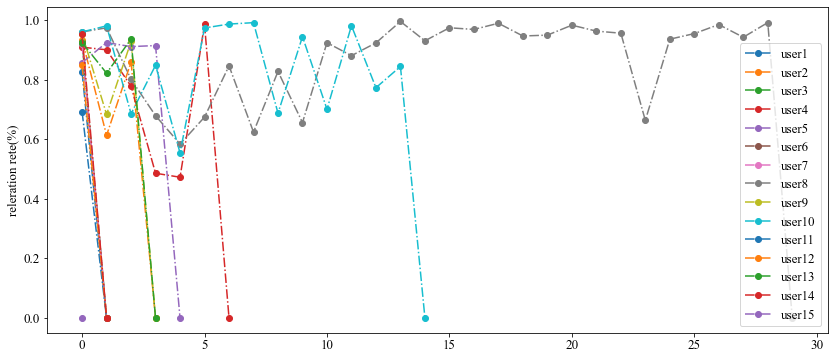

In [72]:
# 同一用户的文章大多相似
plt.figure(figsize=(14, 6))

for i, (_, user_df) in enumerate(sub_user_info.groupby('user_id')):
    item_sim_list = get_item_sim_list(user_df)
    plt.plot(item_sim_list, marker="o", linestyle="-.", label="user"+str(i+1))

plt.legend()
plt.ylabel("releration rete(%)")

**结论：**同一用户所喜欢点击的文章基本高度相似，因此针对某一用户可以展开个性化的推荐，如召回阶段对物品相似度给与更多的权值。

## 总结

通过数据分析的过程， 我们目前可以得到以下几点重要的信息， 这个对于我们进行后面的特征制作和分析非常有帮助：
1. 训练集和测试集的用户id没有重复，也就是测试集里面的用户模型是没有见过的
2. 训练集中用户最少的点击文章数是2， 而测试集里面用户最少的点击文章数是1
3. 用户对于文章存在重复点击的情况， 但这个都存在于训练集里面
4. 同一用户的点击环境存在不唯一的情况，后面做这部分特征的时候可以采用统计特征
5. 用户点击文章的次数有很大的区分度，后面可以根据这个制作衡量用户活跃度的特征
6. 文章被用户点击的次数也有很大的区分度，后面可以根据这个制作衡量文章热度的特征
7. 用户看的新闻，相关性是比较强的，所以往往我们判断用户是否对某篇文章感兴趣的时候， 在很大程度上会和他历史点击过的文章有关
8. 用户点击的文章字数有比较大的区别， 这个可以反映用户对于文章字数的区别
9. 用户点击过的文章主题也有很大的区别， 这个可以反映用户的主题偏好
10.不同用户点击文章的时间差也会有所区别， 这个可以反映用户对于文章时效性的偏好

所以根据上面的一些分析，可以更好的帮助我们后面做好特征工程， 充分挖掘数据的隐含信息。